In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from scipy.stats.kde import gaussian_kde
import scipy.signal as signal
%matplotlib inline
from IPython.html import widgets
from IPython.html.widgets import interact,fixed

In [26]:
execfile('/notebooks/assay-explorer/src/display_utils.py')

In [27]:
filepaths = {'ssC drug data': '/notebooks/moldev-data/analyzed/07-20-2015/ssC-cells.csv',
             'APB drug data': '/notebooks/moldev-data/analyzed/07-20-2015/APB-cells.csv'}
threshold_filepaths = {'ssC drug data': '/notebooks/moldev-data/analyzed/07-20-2015/ssC-thresholds.csv',
                       'APB drug data': '/notebooks/moldev-data/analyzed/07-20-2015/APB-thresholds.csv'}

In [28]:
mydataset = widgets.Dropdown(options=['ssC drug data','APB drug data'])

# Select dataset

In [40]:
mydataset

In [50]:
filepath = filepaths[mydataset.value]
threshold_filepath = threshold_filepaths[mydataset.value]

In [51]:
cells = pd.read_csv(filepath)

In [43]:
# [Float] -> Float
def get_threshold(intensity,bw = 0.35):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,bw)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold

In [44]:
# # Create dummy file with thresholds
# condition_groups = cells.groupby('Condition')

# def get_threshold_from_group(group):
#     groupname = group[0]
#     groupdata = group[1]
#     intensities = groupdata['NucIntegrated Intensity_Avg']
#     return {'Condition': groupname,
#             'Threshold': get_threshold(intensities,0.5)}

# initial_thresholds = pd.DataFrame(map(get_threshold_from_group,condition_groups))

In [45]:
# initial_thresholds.to_csv(threshold_file_path,index=False)

In [84]:
# [Num] -> Float -> SideEffect[Plot]
def plot_gaussian_kde(X,bw,color='k',alpha=1):
    kde_fit = gaussian_kde(X,bw)
    x = np.linspace(min(X),
                    max(X),
                    1000)
    y = kde_fit(x)
    plt.plot(x,y,color=color,alpha = alpha)

In [100]:
def determine_thresholding_parameters \
(data,condition,other_condition,bw,manually_set_threshold,show):
    method = show
    intensities = data[data['Condition'] == condition]['NucIntegrated Intensity_Avg']
    
    plot_gaussian_kde(intensities,bw,color='r')
    plt.title(condition)
    plt.xlim(0,1.5e8)
    plt.ylim(0,5.5e-8)
    plt.xlabel('NucIntegrated Intensity_Avg')
    
    # Plot thresholds
    auto_threshold = get_threshold(intensities,bw)
    threshold_data = pd.read_csv(threshold_filepath)
    other_conditions_threshold = threshold_data[threshold_data['Condition'] == other_condition]['Threshold'].values.tolist()[0]
    saved_threshold = threshold_data[threshold_data['Condition'] == condition]['Threshold'].values.tolist()[0]
    
    lw = 3
    alpha = 0.3
    
    if method == 'Auto':
        plt.plot([auto_threshold,auto_threshold],plt.gca().get_ylim(),color = 'r',linewidth = lw,alpha = alpha,label='Auto')
    elif method == 'Manual':
        plt.plot([manually_set_threshold,manually_set_threshold],plt.gca().get_ylim(),color='g',linewidth = lw,alpha = alpha,label='Manual')
    elif method == 'Other Condition':
        other_intensities = data[data['Condition'] == other_condition]['NucIntegrated Intensity_Avg']
        plot_gaussian_kde(other_intensities,bw,color='b',alpha=0.5)
        plt.plot([other_conditions_threshold,other_conditions_threshold],plt.gca().get_ylim(),color='b',linewidth = lw,alpha = alpha,label='Other Condition')
    elif method == 'Saved Value':
        plt.plot([saved_threshold,saved_threshold],plt.gca().get_ylim(),color='k',linewidth = lw,alpha = alpha,label='Saved Value')
    
    plt.legend()
    
#     threshs = {'Auto': auto_threshold,
#                'Manual': manually_set_threshold,
#                'Other Condition': other_conditions_threshold}
#     colors = {'Auto': 'r',
#                'Manual': 'g',
#                'Other Condition': 'b'}
#     plt.plot(threshs[method],0.5e-8,'ko',markersize=10,color=colors[method],alpha = alpha)
        

# Cell Phase Separation
To find the intensity value that separates G1 from S/G2 cells, I plot the distribution of `NucIntegrated Intensity_Avg`, then smooth it out. 

In the plot below, there are three sliders. 
1. Condition - check out different conditions 
2. Display_bw - smooth out the plot (doesn't affect the calculation of the threshold)
3. Threshold_vw - smooth out the distribution for the calculation. 

Set the display_bw and threshold_bw to the same value to 'see what the computer sees' when it chooses a threshold.

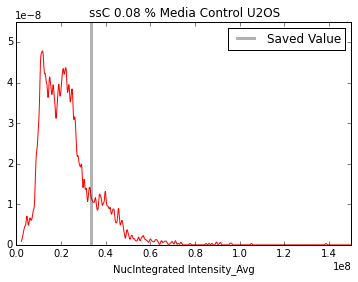

In [101]:
n_conditions = len(cells['Condition'].unique())
bw = {'min':0.025, 'max': 0.8, 'step':0.025}
intensities = cells['NucIntegrated Intensity_Avg']
thresh = {'min': intensities.min(),
          'max': intensities.max(),
          'step': (intensities.max() - intensities.min())/200,
          'init': intensities.median()}

interact(
    determine_thresholding_parameters,
    data = fixed(cells),
    condition = widgets.Select(options = cells['Condition'].unique().tolist()),
    other_condition = widgets.Select(options = cells['Condition'].unique().tolist()),
    bw = widgets.FloatSlider(min = bw['min'], max = bw['max'], step = bw['step']),
    manually_set_threshold = widgets.FloatSlider(min = thresh['min'], max = thresh['max'], step = thresh['step'],value=thresh['init']),
    show = widgets.ToggleButtons(options=['Manual','Auto','Other Condition','Saved Value']));

